In [33]:
cd /home/dmoi/projects/foldtree2

/home/dmoi/projects/foldtree2


# Protein Structure Graph Construction and Analysis

This notebook demonstrates the process of converting protein structures (PDB files) into graph representations suitable for geometric deep learning. The workflow includes:

- Downloading and parsing PDB files using Bio.PDB.
- Extracting residue-level features, backbone and contact maps, bond angles, and other structural properties.
- Converting structures into PyTorch Geometric HeteroData objects for downstream machine learning tasks.
- Visualizing structural features such as Ramachandran plots.
- Preparing large datasets of protein structures for training graph neural networks.

The notebook leverages custom modules (e.g., `src.pdbgraph.PDB2PyG`) for feature extraction and graph construction, and supports efficient data loading and batching for large-scale experiments.

In [34]:
import wget
#download an example pdb file
filename = './1eei (1).pdb'
url = 'https://files.rcsb.org/download/1EEI.pdb'
#filename = wget.download(url)
datadir = '../../datasets/foldtree2/'

In [35]:
#use autoreload to reload modules
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from foldtree2.src import pdbgraph
import importlib
importlib.reload(pdbgraph)
converter = pdbgraph.PDB2PyG( 
aapropcsv = 'foldtree2/config/aaindex1.csv'
)

In [37]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pydssp
import tqdm
from Bio.PDB import PDBParser   
import numpy as np

@> WARNING outfile ./tmp/addH_A0A0C2GTF1.pdb already exists, so returning it. Set overwrite=True to overwrite it
@> 4929 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> Calculating interactions.


./tmp/addH_A0A0C2GTF1.pdb


@> Calculating hydrogen bonds.
@>      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
@>     ARG210    A      NH2_1608  <--->     ASP225    A      OD2_1722     2.6    35.4
@>     CYS145    A        N_1084  <--->     VAL131    A         O_967     2.7    36.9
@>      GLN88    A         N_658  <--->      PRO53    A         O_379     2.7    10.1
@>     LEU235    A        N_1788  <--->     ILE221    A        O_1679     2.7    22.6
@>     THR226    A      OG1_1729  <--->     ARG210    A        O_1603     2.7    11.4
@>      ARG12    A        NH1_83  <--->      GLU20    A       OE1_144     2.8    31.2
@>     SER257    A       OG_1951  <--->     CYS241    A        O_1832     2.8    25.4
@>      LEU81    A         N_601  <--->      SER10    A          O_66     2.8    27.0
@>      LEU83    A         N_615  <--->      ARG12    A          O_79     2.8     6.8
@>     HIS238    A      ND1_1813  <--->     ASP259    A      OD2_1968     2.8    26.2
@>     ASN289    A   

15
324
chains: ['A']
sequence: MDDGPVGQVSVRFVGEDGNELGGAGILLPTSVTCNQLQILCNQLLESSDDPVPISFFTEDGVEIVDSIEKSLDKIDYEKTLCLVYQPQAVFRVQPVTRCSSSMPGHGEPVISAQFSPDGRGLASGSGDTTVRIWDIDTELPLFTCKGHKNWVLCIAWSPDAKKIASACKNGQIMIWDSATGAQIGKTLSRHKQWITYLAWQPMHKDSKCRLLASAGKDGNIHIWDTVQGTVVRSLSGHTACVTSIRWGGEGLIYSGSQDRTVKVWRASDGIICRNLSGHAHWINTLALNTDYALRTSCFDPKTGCSRPATEEEQPVNYICIFEI
length of sequence: 324
df:     single_letter_code  Phi_Angle  Psi_Angle  Omega_Angle     0     1     2  \
0                    M   0.000000   0.000000     0.000000  4.52  1.18  2.67   
1                    M  -2.095325   1.401867     2.957922  4.52  1.18  2.67   
2                    D  -1.432059   1.588184     2.834631  4.76  0.46  0.05   
3                    D  -1.046471   2.792876     3.140989  4.76  0.46  0.05   
4                    G  -1.011939   2.037016     3.095035  3.97  0.07  0.49   
..                 ...        ...        ...          ...   ...   ...   ...   
319                  I  -0.968777   1.827866     2.947370  3.95

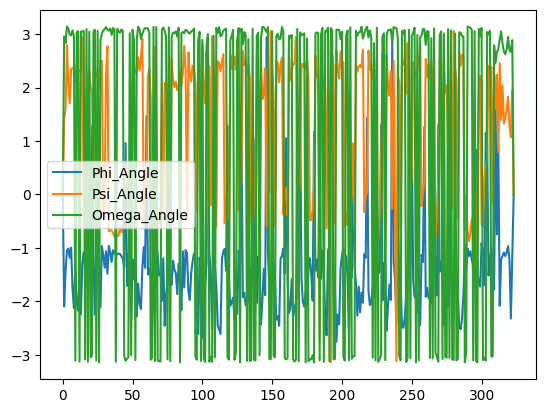

In [38]:
#filename = './foldtree2/config/1eei.pdb'
filename = './tmp/A0A0C2GTF1.pdb'
res  = converter.create_features(filename, distance = 10, verbose = False , add_prody = True)
print(len(res))
angles, contact_points, ss , hbond_mat, backbone , backbone_rev , positional_encoding , plddt , aa , bondangles , foldxvals , coords , window, windowrev, prodymats = res
print( len(angles) )

#read the pdb file
parser = PDBParser()
structure = parser.get_structure('1eei', filename)
model = structure[0]

aa_dict = {
'ALA': 'A',
'ARG': 'R',
'ASN': 'N',
'ASP': 'D',
'CYS': 'C',
'GLN': 'Q',
'GLU': 'E',
'GLY': 'G',
'HIS': 'H',
'ILE': 'I',
'LEU': 'L',
'LYS': 'K',
'MET': 'M',
'PHE': 'F',
'PRO': 'P',
'SER': 'S',
'THR': 'T',
'TRP': 'W',
'TYR': 'Y',
'VAL': 'V'

}
#extract the sequence
seq = ''
chains = model.get_chains()
print('chains:', [chain.id for chain in chains])
chain = model['A']  # Assuming you want the first chain
for residue in chain:
	if PDB.is_aa(residue) and residue.get_resname() in aa_dict:
		seq += aa_dict[residue.get_resname()]
print('sequence:' , seq)
print('length of sequence:', len(seq))
print('df:', angles)
angles[['Phi_Angle', 'Psi_Angle' , 'Omega_Angle']].plot()
plt.show()

prody matrix key: SBs
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 18 stored elements and shape (324, 324)>
  Coords	Values
  (11, 19)	1.0
  (19, 11)	1.0
  (49, 301)	1.0
  (75, 78)	1.0
  (78, 75)	1.0
  (190, 221)	1.0
  (204, 249)	1.0
  (209, 224)	1.0
  (221, 190)	1.0
  (224, 209)	1.0
  (237, 258)	1.0
  (245, 290)	1.0
  (249, 204)	1.0
  (258, 237)	1.0
  (265, 268)	1.0
  (268, 265)	1.0
  (290, 245)	1.0
  (301, 49)	1.0
matrix shape: (324, 324)


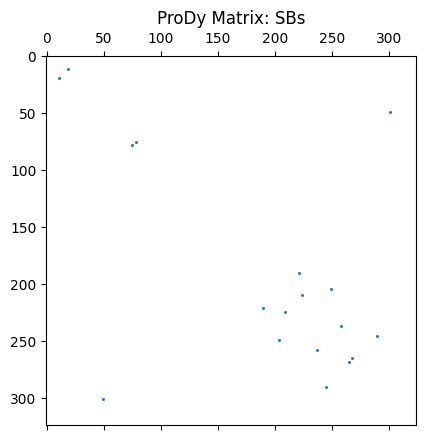

prody matrix key: RIB
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (324, 324)>
  Coords	Values
  (190, 221)	1.0
  (221, 190)	1.0
matrix shape: (324, 324)


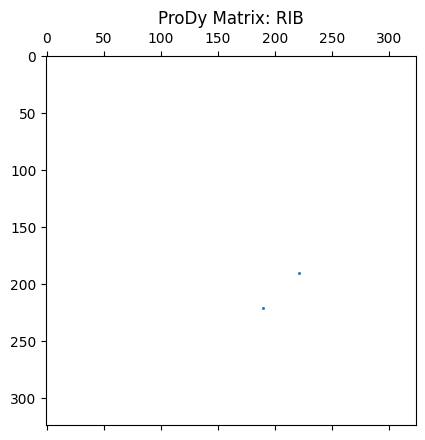

prody matrix key: HBs
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 214 stored elements and shape (324, 324)>
  Coords	Values
  (6, 29)	2.0
  (8, 27)	2.0
  (9, 79)	1.0
  (9, 80)	1.0
  (10, 25)	2.0
  (11, 19)	1.0
  (11, 80)	1.0
  (11, 82)	1.0
  (12, 20)	1.0
  (13, 82)	1.0
  (13, 84)	1.0
  (14, 18)	1.0
  (18, 14)	1.0
  (19, 11)	1.0
  (20, 12)	1.0
  (25, 10)	2.0
  (27, 8)	2.0
  (29, 6)	2.0
  (29, 68)	1.0
  (31, 67)	1.0
  (32, 35)	1.0
  (32, 36)	1.0
  (33, 37)	1.0
  (33, 65)	1.0
  (34, 38)	1.0
  :	:
  (262, 274)	1.0
  (263, 273)	2.0
  (264, 252)	2.0
  (265, 269)	1.0
  (265, 270)	1.0
  (266, 250)	1.0
  (269, 265)	1.0
  (270, 265)	1.0
  (273, 263)	2.0
  (274, 262)	1.0
  (275, 261)	2.0
  (279, 259)	1.0
  (282, 256)	1.0
  (287, 290)	1.0
  (288, 323)	1.0
  (289, 293)	1.0
  (290, 287)	1.0
  (291, 295)	2.0
  (292, 296)	1.0
  (293, 289)	1.0
  (295, 291)	2.0
  (296, 292)	1.0
  (299, 304)	1.0
  (304, 299)	1.0
  (323, 288)	1.0
matrix shape: (324, 324)


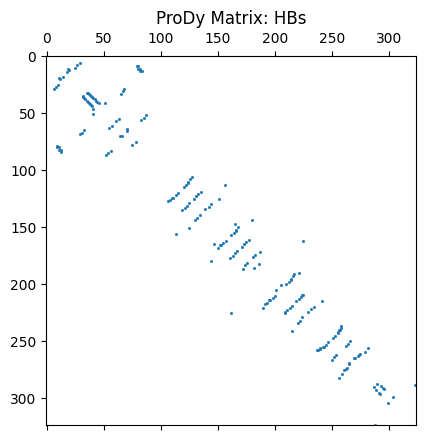

prody matrix key: PiCat
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6 stored elements and shape (324, 324)>
  Coords	Values
  (150, 168)	1.0
  (168, 150)	1.0
  (190, 221)	1.0
  (193, 216)	1.0
  (216, 193)	1.0
  (221, 190)	1.0
matrix shape: (324, 324)


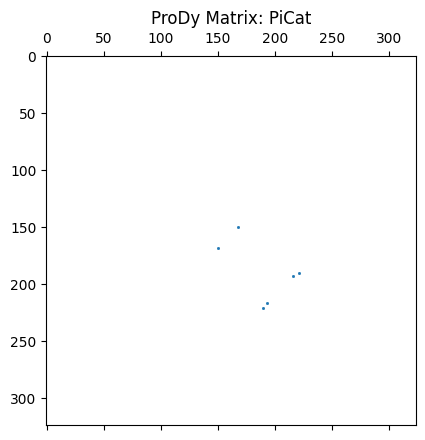

prody matrix key: HPh
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 250 stored elements and shape (324, 324)>
  Coords	Values
  (8, 74)	1.0
  (8, 76)	1.0
  (8, 80)	1.0
  (10, 12)	1.0
  (10, 27)	1.0
  (10, 67)	1.0
  (10, 82)	1.0
  (11, 13)	1.0
  (12, 10)	1.0
  (12, 25)	1.0
  (12, 36)	1.0
  (12, 39)	1.0
  (12, 43)	1.0
  (12, 82)	1.0
  (13, 11)	1.0
  (20, 84)	1.0
  (25, 12)	1.0
  (25, 27)	1.0
  (25, 39)	1.0
  (25, 43)	1.0
  (27, 10)	1.0
  (27, 25)	1.0
  (31, 36)	1.0
  (36, 12)	1.0
  (36, 31)	1.0
  :	:
  (262, 264)	1.0
  (262, 271)	1.0
  (263, 251)	1.0
  (263, 253)	1.0
  (264, 220)	1.0
  (264, 234)	1.0
  (264, 252)	1.0
  (264, 262)	1.0
  (264, 271)	1.0
  (266, 222)	1.0
  (266, 246)	1.0
  (266, 252)	1.0
  (271, 262)	1.0
  (271, 264)	1.0
  (275, 261)	1.0
  (281, 259)	1.0
  (282, 261)	1.0
  (285, 245)	1.0
  (285, 261)	1.0
  (287, 245)	1.0
  (287, 253)	1.0
  (298, 160)	1.0
  (301, 89)	1.0
  (315, 317)	1.0
  (317, 315)	1.0
matrix shape: (324, 324)


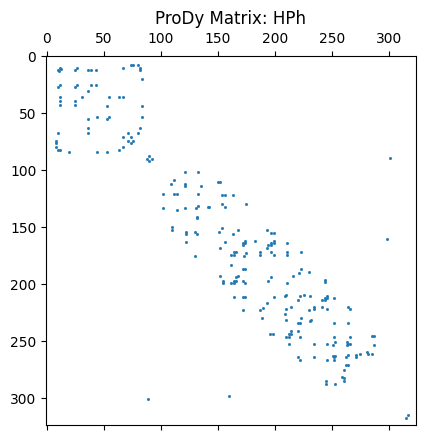

prody matrix key: DiBs
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (324, 324)>
  Coords	Values
  (190, 221)	1.0
  (221, 190)	1.0
matrix shape: (324, 324)


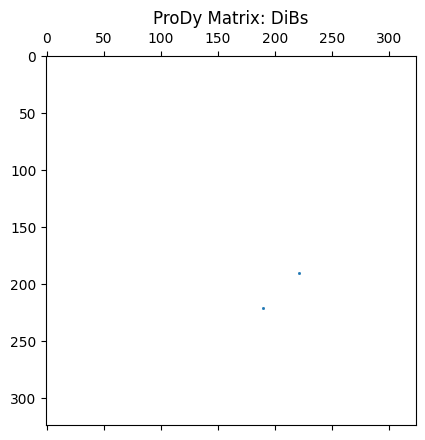

prody matrix key: Energy
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 456 stored elements and shape (324, 324)>
  Coords	Values
  (6, 29)	-1.81
  (8, 27)	-6.03
  (8, 74)	-5.31
  (8, 76)	-4.54
  (8, 80)	-6.03
  (9, 79)	-2.22
  (9, 80)	-4.12
  (10, 12)	-5.33
  (10, 25)	-5.31
  (10, 27)	-6.03
  (10, 67)	-5.31
  (10, 82)	-6.03
  (11, 13)	-3.7
  (11, 19)	-4.05
  (11, 80)	-5.01
  (11, 82)	-5.01
  (12, 10)	-5.33
  (12, 20)	-6.65
  (12, 25)	-6.11
  (12, 36)	-6.65
  (12, 39)	-6.65
  (12, 43)	-6.65
  (12, 82)	-6.65
  (13, 11)	-3.7
  (13, 82)	-6.03
  :	:
  (281, 259)	-4.54
  (282, 256)	-3.47
  (282, 261)	-5.31
  (285, 245)	-5.01
  (285, 261)	-6.03
  (287, 245)	-5.01
  (287, 253)	-5.67
  (287, 290)	-4.16
  (288, 323)	-3.42
  (289, 293)	-4.28
  (290, 245)	-3.92
  (290, 287)	-4.16
  (291, 295)	-3.33
  (292, 296)	-2.49
  (293, 289)	-4.28
  (295, 291)	-3.33
  (296, 292)	-2.49
  (298, 160)	-4.43
  (299, 304)	-3.56
  (301, 49)	-2.47
  (301, 89)	-2.19
  (304, 299)	-3.56
  (315, 317)	-4.5

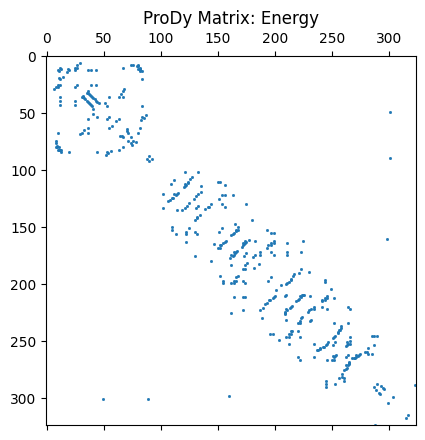

In [39]:
#show prody matrices
for key in prodymats:
	print('prody matrix key:', key)
	print(prodymats[key])
	print('matrix shape:', prodymats[key].shape)
	plt.spy(prodymats[key].toarray() , markersize=1)
	plt.title(f'ProDy Matrix: {key}')
	plt.show()

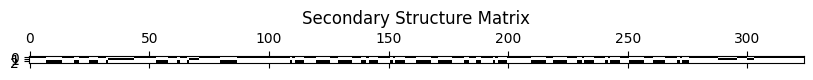

ss shape: torch.Size([324, 3])


In [40]:
plt.figure( figsize=(10,10) )
plt.title('Secondary Structure Matrix')

plt.spy(ss.T)
plt.show()
print('ss shape:', ss.shape)

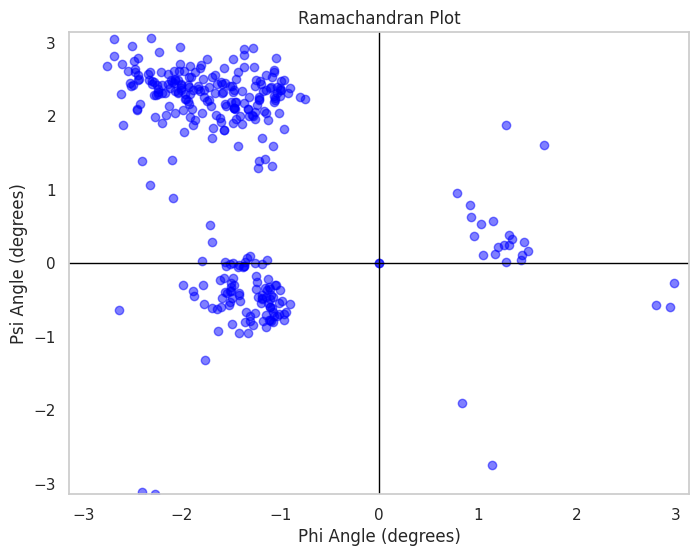

In [41]:
#plot ramachandran
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.scatter(angles['Phi_Angle'], angles['Psi_Angle'], c='blue', alpha=0.5)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title('Ramachandran Plot')
plt.xlabel('Phi Angle (degrees)')
plt.ylabel('Psi Angle (degrees)')
plt.grid()
plt.show()

     0     1     2     3     4     5     6      7      8      9   ...   10  \
A  4.35  0.61  1.18  1.56  1.00  0.77  0.37  0.357   52.6   16.0  ...  0.0   
R  4.38  0.60  0.20  0.45  0.52  0.72  0.84  0.529  109.1  -70.0  ...  0.0   
N  4.75  0.06  0.23  0.27  0.35  0.55  0.97  0.463   75.7  -74.0  ...  0.0   
D  4.76  0.46  0.05  0.14  0.44  0.65  0.97  0.511   68.4  -78.0  ...  0.0   
C  4.65  1.07  1.89  1.23  0.06  0.65  0.84  0.346   68.3  168.0  ...  0.0   
Q  4.37  0.00  0.72  0.51  0.44  0.72  0.64  0.493   89.7  -73.0  ...  0.0   
E  4.29  0.47  0.11  0.23  0.73  0.55  0.53  0.497   84.7 -106.0  ...  0.0   
G  3.97  0.07  0.49  0.62  0.35  0.65  0.97  0.544   36.3  -13.0  ...  0.0   
H  4.63  0.61  0.31  0.29  0.60  0.83  0.75  0.323   91.9   50.0  ...  0.0   
I  3.95  2.22  1.45  1.67  0.73  0.98  0.37  0.462  102.0  151.0  ...  0.0   
L  4.17  1.53  3.23  2.93  1.00  0.83  0.53  0.365  102.0  145.0  ...  1.0   
K  4.36  1.15  0.06  0.15  0.60  0.55  0.75  0.466  105.1 -141.0

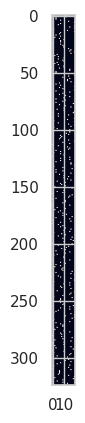

contacts (324, 324)


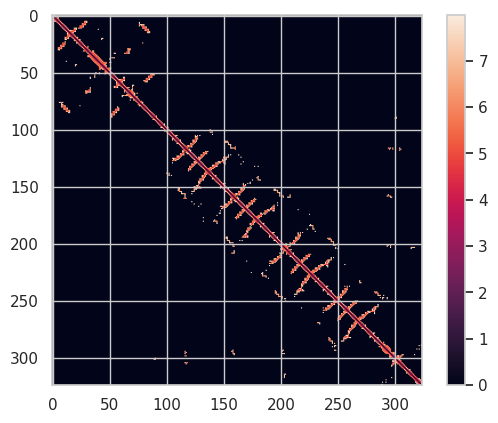

torch.Size([1, 324, 4, 3])
hbond (324, 324)


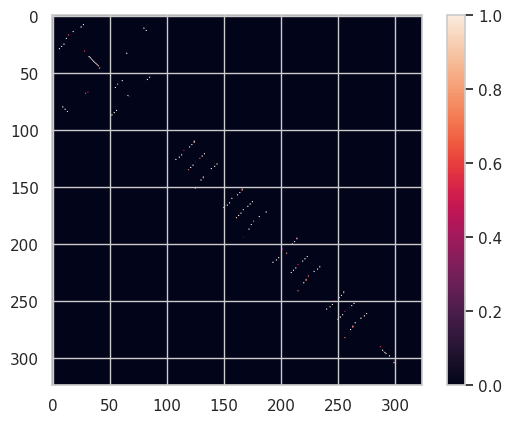

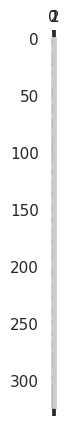

positions (324, 256)


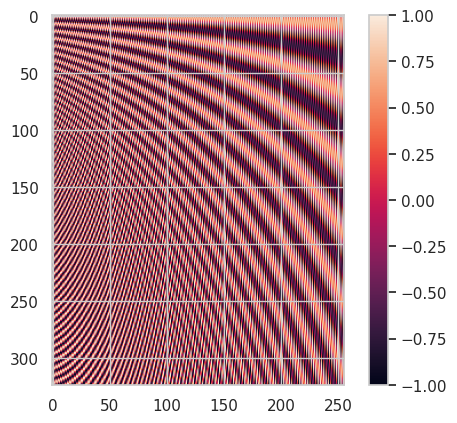

vals (324, 845)


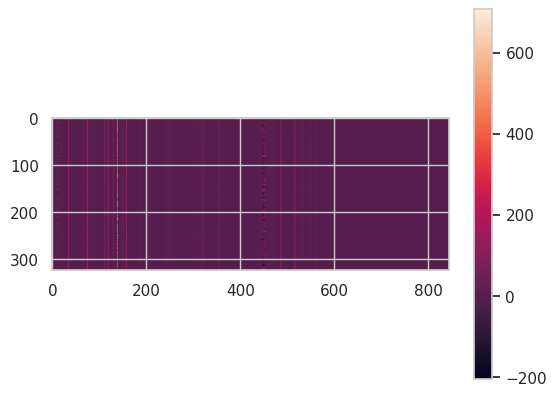

plddt (324, 1)


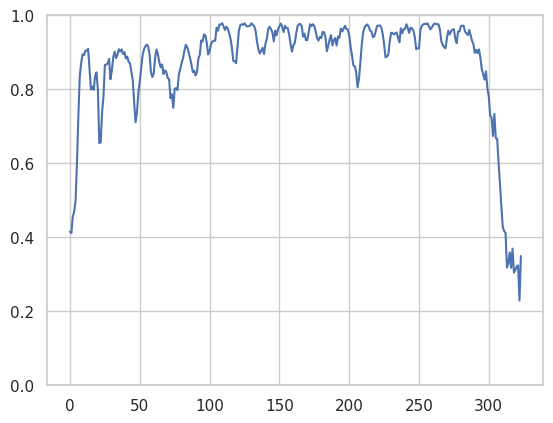

@> WARNING outfile ./tmp/addH_A0A0C2GTF1.pdb already exists, so returning it. Set overwrite=True to overwrite it
@> 4929 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Calculating interactions.


./tmp/addH_A0A0C2GTF1.pdb


@> Calculating hydrogen bonds.
@>      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
@>     ARG210    A      NH2_1608  <--->     ASP225    A      OD2_1722     2.6    35.4
@>     CYS145    A        N_1084  <--->     VAL131    A         O_967     2.7    36.9
@>      GLN88    A         N_658  <--->      PRO53    A         O_379     2.7    10.1
@>     LEU235    A        N_1788  <--->     ILE221    A        O_1679     2.7    22.6
@>     THR226    A      OG1_1729  <--->     ARG210    A        O_1603     2.7    11.4
@>      ARG12    A        NH1_83  <--->      GLU20    A       OE1_144     2.8    31.2
@>     SER257    A       OG_1951  <--->     CYS241    A        O_1832     2.8    25.4
@>      LEU81    A         N_601  <--->      SER10    A          O_66     2.8    27.0
@>      LEU83    A         N_615  <--->      ARG12    A          O_79     2.8     6.8
@>     HIS238    A      ND1_1813  <--->     ASP259    A      OD2_1968     2.8    26.2
@>     ASN289    A   

prody SBs (324, 324)


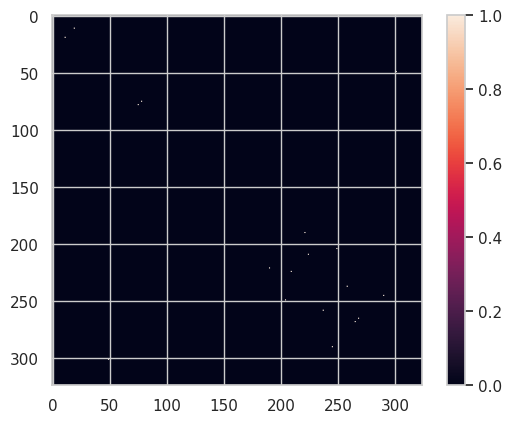

prody RIB (324, 324)


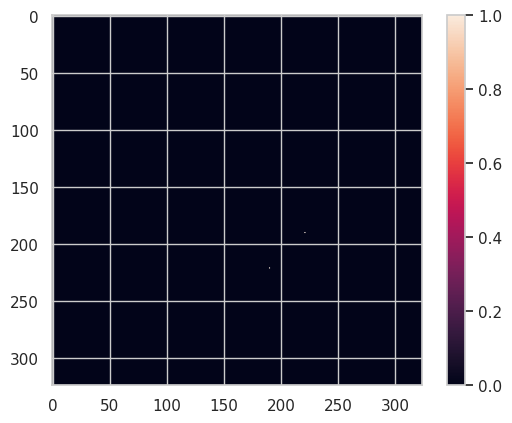

prody HBs (324, 324)


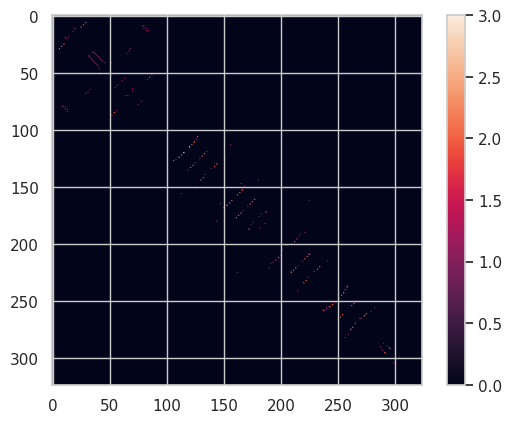

prody PiCat (324, 324)


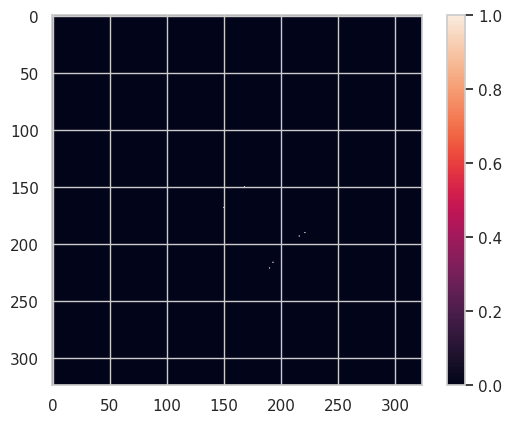

prody HPh (324, 324)


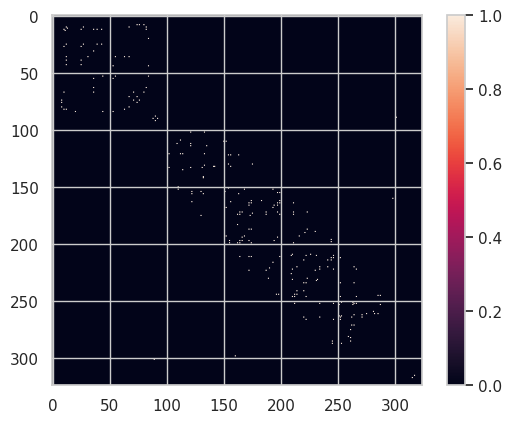

prody DiBs (324, 324)


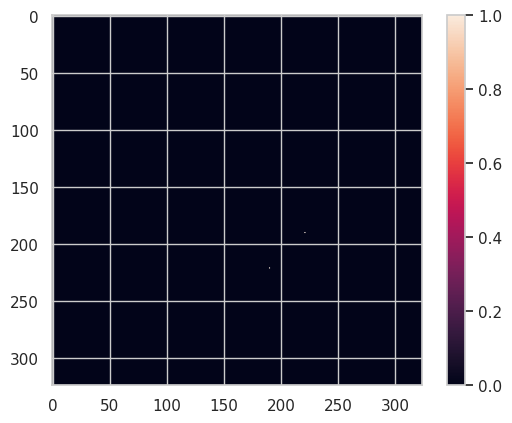

prody Energy (324, 324)


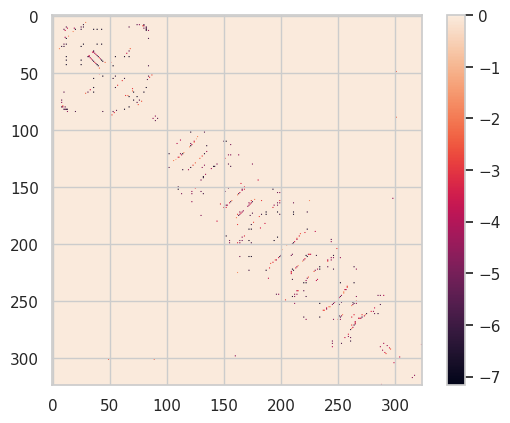

data: HeteroData(
  identifier='A0A0C2GTF1',
  AA={ x=[324, 20] },
  coords={ x=[324, 3] },
  R_true={ x=[324, 3, 3] },
  t_true={ x=[324, 3] },
  bondangles={ x=[324, 3] },
  plddt={ x=[324, 1] },
  positions={ x=[324, 256] },
  res={ x=[324, 857] },
  fourier1dr={ x=[324, 80] },
  fourier1di={ x=[324, 80] },
  fourier2dr={ x=[1, 1300] },
  fourier2di={ x=[1, 1300] },
  ss={ x=[324, 3] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={
    edge_attr=[323],
    edge_index=[2, 647],
  },
  (res, backbonerev, res)={
    edge_attr=[323],
    edge_index=[2, 647],
  },
  (res, contactPoints, res)={
    edge_attr=[3106],
    edge_index=[2, 3106],
  },
  (res, hbond, res)={
    edge_attr=[246],
    edge_index=[2, 246],
  },
  (res, window, res)={
    edge_attr=[644],
    edge_index=[2, 644],
  },
  (res, windowrev, res)={
    edge_attr=[323],
    edge_index=[2, 323],
  },
  (res, prody_SBs, res)={
    edge_index=[2, 18],
    edge_attr=[18],
  },
  (res, prody_

In [42]:
data = converter.struct2pyg( filename , verbose = True , add_prody = True )
print('data:', data)

In [43]:
import multiprocessing as mp
import tqdm
import os
import numpy as np
import wget 
import pandas as pd

datadir = '/mnt/data2/datasets/'
cols = 'repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId'.split('_')
repdf = pd.read_table(datadir+ 'afdbclusters/2-repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId.tsv')
repdf.columns = cols
print(repdf.head() , len(repdf))
def download_pdb(rep ,structdir = datadir+'structs/'):
	url = f'https://alphafold.ebi.ac.uk/files/AF-{rep}-F1-model_v4.pdb'
	#check if file exists
	if os.path.exists( structdir + rep + '.pdb'):
		return structdir + rep + '.pdb'
	filename = wget.download(url, out=structdir + rep + '.pdb')
	return filename

def download(repdf , nreps = 100 , structdir = datadir +'structs/'):
	if not os.path.exists(structdir):
		os.makedirs(structdir)
	reps = repdf.repId.unique()
	if nreps:
		#select a random sample of representatives
		reps = np.random.choice(reps, nreps)
	with mp.Pool(20) as p:
		filenames = p.map(download_pdb, tqdm.tqdm(reps))
		return filenames
		


        repId  isDark  nMem  repLen   avgLen  repPlddt  avgPlddt  LCAtaxId
0  A0A6M1CKG1       0     3     122  122.667     96.06   88.1467     91347
1  A0A4Q3Q6P1       1     3     117  113.333     71.94   67.8333     80864
2  A0A4V3EFQ4       0     3     153  156.000     68.56   58.8533    131567
3  A0A4V3EKB1       1     3      51   51.000     62.62   62.7700      1883
4  A0A4V3EP89       0     2      96   94.500     70.88   72.1900   2593676 2302907


In [44]:
#download(repdf, nreps = 10000 , structdir = '../datasets/foldtree2/structs/' )

In [45]:
import torch
import os
import numpy as np
# Setting the seed for everything
torch.manual_seed(0)
np.random.seed(0)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [46]:
data_sample =converter.struct2pyg( filename, verbose=False , add_prody = True )
print(data_sample)
ndim = data_sample['res'].x.shape[1]
ndim_godnode = data_sample['godnode'].x.shape[1]
ss = data_sample['ss'].x
print('ss shape:', ss.shape)

@> WARNING outfile ./tmp/addH_A0A0C2GTF1.pdb already exists, so returning it. Set overwrite=True to overwrite it
@> 4929 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Calculating interactions.


./tmp/addH_A0A0C2GTF1.pdb


@> Calculating hydrogen bonds.
@>      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
@>     ARG210    A      NH2_1608  <--->     ASP225    A      OD2_1722     2.6    35.4
@>     CYS145    A        N_1084  <--->     VAL131    A         O_967     2.7    36.9
@>      GLN88    A         N_658  <--->      PRO53    A         O_379     2.7    10.1
@>     LEU235    A        N_1788  <--->     ILE221    A        O_1679     2.7    22.6
@>     THR226    A      OG1_1729  <--->     ARG210    A        O_1603     2.7    11.4
@>      ARG12    A        NH1_83  <--->      GLU20    A       OE1_144     2.8    31.2
@>     SER257    A       OG_1951  <--->     CYS241    A        O_1832     2.8    25.4
@>      LEU81    A         N_601  <--->      SER10    A          O_66     2.8    27.0
@>      LEU83    A         N_615  <--->      ARG12    A          O_79     2.8     6.8
@>     HIS238    A      ND1_1813  <--->     ASP259    A      OD2_1968     2.8    26.2
@>     ASN289    A   

HeteroData(
  identifier='A0A0C2GTF1',
  AA={ x=[324, 20] },
  coords={ x=[324, 3] },
  R_true={ x=[324, 3, 3] },
  t_true={ x=[324, 3] },
  bondangles={ x=[324, 3] },
  plddt={ x=[324, 1] },
  positions={ x=[324, 256] },
  res={ x=[324, 857] },
  fourier1dr={ x=[324, 80] },
  fourier1di={ x=[324, 80] },
  fourier2dr={ x=[1, 1300] },
  fourier2di={ x=[1, 1300] },
  ss={ x=[324, 3] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={
    edge_attr=[323],
    edge_index=[2, 647],
  },
  (res, backbonerev, res)={
    edge_attr=[323],
    edge_index=[2, 647],
  },
  (res, contactPoints, res)={
    edge_attr=[3106],
    edge_index=[2, 3106],
  },
  (res, hbond, res)={
    edge_attr=[246],
    edge_index=[2, 246],
  },
  (res, window, res)={
    edge_attr=[644],
    edge_index=[2, 644],
  },
  (res, windowrev, res)={
    edge_attr=[323],
    edge_index=[2, 323],
  },
  (res, prody_SBs, res)={
    edge_index=[2, 18],
    edge_attr=[18],
  },
  (res, prody_RIB, r

In [47]:
print(data_sample['res'].x.shape)

torch.Size([324, 857])


In [48]:
import glob
pdbfiles = glob.glob(datadir+'structs/*.pdb')
data_sample =converter.struct2pyg( pdbfiles[0], foldxdir=None) #)'./foldx/',  verbose=False)
print(data_sample)

HeteroData(
  identifier='A0A3D1FGS9',
  AA={ x=[259, 20] },
  coords={ x=[259, 3] },
  R_true={ x=[259, 3, 3] },
  t_true={ x=[259, 3] },
  bondangles={ x=[259, 3] },
  plddt={ x=[259, 1] },
  positions={ x=[259, 256] },
  res={ x=[259, 857] },
  fourier1dr={ x=[259, 80] },
  fourier1di={ x=[259, 80] },
  fourier2dr={ x=[1, 1300] },
  fourier2di={ x=[1, 1300] },
  ss={ x=[259, 3] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={
    edge_attr=[258],
    edge_index=[2, 517],
  },
  (res, backbonerev, res)={
    edge_attr=[258],
    edge_index=[2, 517],
  },
  (res, contactPoints, res)={
    edge_attr=[2550],
    edge_index=[2, 2550],
  },
  (res, hbond, res)={
    edge_attr=[282],
    edge_index=[2, 282],
  },
  (res, window, res)={
    edge_attr=[514],
    edge_index=[2, 514],
  },
  (res, windowrev, res)={
    edge_attr=[258],
    edge_index=[2, 258],
  },
  (res, informs, godnode)={ edge_index=[2, 259] },
  (godnode, informs, res)={ edge_index=[2, 2

In [49]:
#shuffle the data
np.random.shuffle(pdbfiles)
#converter.store_pyg(pdbfiles[0:7500], filename='structs_train_final.h5', foldxdir = None, verbose = False , add_prody = True , distance=15)

In [32]:
converter.store_pyg_mp(pdbfiles[0:10], filename='structs_mptest.h5', foldxdir = None, verbose = True , add_prody = False , ncpu= 25 , distance=15 )

{'foldxdir': None, 'add_prody': False, 'distance': 15}


Processing and storing PDB files:  40%|███████████████████▌                             | 4/10 [01:40<01:53, 18.97s/it]

Error processing future: [Errno Task timeout] 100
Traceback (most recent call last):
  File "/home/dmoi/projects/foldtree2/foldtree2/src/pdbgraph.py", line 893, in store_pyg_mp
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
TimeoutError: [Errno Task timeout] 100

Error processing future: [Errno Task timeout] 100
Traceback (most recent call last):
  File "/home/dmoi/projects/foldtree2/foldtree2/src/pdbgraph.py", line 893, in store_pyg_mp
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/min

Processing and storing PDB files:  70%|██████████████████████████████████▎              | 7/10 [01:40<00:26,  8.85s/it]

Error processing future: [Errno Task timeout] 100
Traceback (most recent call last):
  File "/home/dmoi/projects/foldtree2/foldtree2/src/pdbgraph.py", line 893, in store_pyg_mp
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
TimeoutError: [Errno Task timeout] 100

Error processing future: [Errno Task timeout] 100
Traceback (most recent call last):
  File "/home/dmoi/projects/foldtree2/foldtree2/src/pdbgraph.py", line 893, in store_pyg_mp
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/min

Processing and storing PDB files: 100%|████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.07s/it]

Error processing future: [Errno Task timeout] 100
Traceback (most recent call last):
  File "/home/dmoi/projects/foldtree2/foldtree2/src/pdbgraph.py", line 893, in store_pyg_mp
    result = future.result()
             ^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
TimeoutError: [Errno Task timeout] 100




Successfully processed and stored: 0/10
Failed files (10):
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100
  /: Future exception: [Errno Task timeout] 100


[('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100'),
 ('/', 'Future exception: [Errno Task timeout] 100')]

In [ ]:

from torch_geometric.data import DataLoader
from torch_geometric.data import Batch

#load the dataset
struct_dat = pdbgraph.StructureDataset('structs_traininffttest.h5')

train_loader = DataLoader(struct_dat, batch_size=20, shuffle=True , worker_init_fn = np.random.seed(0) , num_workers=4 )
#test out the dataloader
for i, data in enumerate(train_loader):
	print(i)
	print(data)
	if i > 10:
		break


0
HeteroDataBatch(
  identifier=[20],
  AA={
    x=[6058, 20],
    batch=[6058],
    ptr=[21],
  },
  R_true={
    x=[6058, 3, 3],
    batch=[6058],
    ptr=[21],
  },
  bondangles={
    x=[6058, 3],
    batch=[6058],
    ptr=[21],
  },
  coords={
    x=[6058, 3],
    batch=[6058],
    ptr=[21],
  },
  fourier1di={
    x=[6058, 80],
    batch=[6058],
    ptr=[21],
  },
  fourier1dr={
    x=[6058, 80],
    batch=[6058],
    ptr=[21],
  },
  fourier2di={
    x=[20, 1300],
    batch=[20],
    ptr=[21],
  },
  fourier2dr={
    x=[20, 1300],
    batch=[20],
    ptr=[21],
  },
  godnode={
    x=[20, 5],
    batch=[20],
    ptr=[21],
  },
  godnode4decoder={
    x=[20, 5],
    batch=[20],
    ptr=[21],
  },
  plddt={
    x=[6058, 1],
    batch=[6058],
    ptr=[21],
  },
  positions={
    x=[6058, 256],
    batch=[6058],
    ptr=[21],
  },
  res={
    x=[6058, 857],
    batch=[6058],
    ptr=[21],
  },
  t_true={
    x=[6058, 3],
    batch=[6058],
    ptr=[21],
  },
  (godnode4decoder, informs

In [ ]:
pdbfiles_structalign = glob.glob(datadir + 'struct_align/*/structs/*.pdb')

KeyboardInterrupt: 

In [ ]:
converter.store_pyg(pdbfiles_structalign, filename='structalignFFT.h5', verbose = False)

100%|█| 45853/45853 [8:38:59<00:00,  1.47it/


: 

: 

: 

: 